In [1]:
import multiprocessing
print(multiprocessing.cpu_count())


16


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import os
from multiprocessing import Pool, cpu_count

# ---- Set up domain ----
N = 128
s_start, s_end = -64, 64
x = np.linspace(s_start, s_end, N, endpoint=False)
y = np.linspace(s_start, s_end, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")
dx = abs(X[1,0] - X[0,0])

# ---- Initial condition: two droplets ----
def initial_two_droplets(X, Y, R1=10, R2=5, center1=(-20,0), center2=(20,0)):
    phi = -np.ones_like(X)
    mask1 = (X - center1[0])**2 + (Y - center1[1])**2 < R1**2
    mask2 = (X - center2[0])**2 + (Y - center2[1])**2 < R2**2
    phi[mask1] = 1.0
    phi[mask2] = 1.0
    return phi

# ---- FFT-based derivatives (periodic BCs) ----
kx = np.fft.fftfreq(N, d=(s_end - s_start)/N) * 2*np.pi
ky = np.fft.fftfreq(N, d=(s_end - s_start)/N) * 2*np.pi
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX**2 + KY**2
K4 = K2**2

# ---- Simulation parameters ----
a, b, eps_val, M = -0.25, 0.25, 1.0, 1.0
tau = 0.02
t_len = 200 # shorter runs
timesteps = int(t_len / tau)

def run_simulation(lam_val, zeta, phi_0):
    phi = phi_0.copy()
    f_phi = np.fft.fft2(phi)
    for ii in range(timesteps):
        phi3 = phi**3
        dphi_dx = np.fft.ifft2(1j*KX * f_phi).real
        dphi_dy = np.fft.ifft2(1j*KY * f_phi).real
        lap_phi = np.fft.ifft2(-K2 * f_phi).real
        grad_phi2 = dphi_dx**2 + dphi_dy**2
        lap_phi_grad_phi_x = lap_phi * dphi_dx
        lap_phi_grad_phi_y = lap_phi * dphi_dy
        lapl_phi_grad_phi_x_fft = np.fft.fft2(lap_phi_grad_phi_x)
        lapl_phi_grad_phi_y_fft = np.fft.fft2(lap_phi_grad_phi_y)

        nonlinear_term = -K2 * np.fft.fft2(b*phi3 + lam_val*grad_phi2) - 1j * zeta * (KX * lapl_phi_grad_phi_x_fft + KY * lapl_phi_grad_phi_y_fft)
        f_phi = (f_phi + tau*M*nonlinear_term) / (1 + tau*M*(a*K2 + eps_val*K4))
        phi = np.fft.ifft2(f_phi).real
    return phi

# ---- Extract droplet radii ----
def extract_radii(phi):
    mask = phi > 0
    labeled, num_features = label(mask)
    areas = [np.sum(labeled==i) for i in range(1, num_features+1)]
    if len(areas) == 2:
        R1 = np.sqrt(np.max(areas)*dx**2 / np.pi)
        R2 = np.sqrt(np.min(areas)*dx**2 / np.pi)
        return R1, R2
    return None, None

# ---- Function for a single simulation ----
def single_simulation(args):
    i, j, lam_val, zeta = args
    print(f"[{i},{j}] Starting simulation: zeta={zeta:.2f}, lambda={lam_val:.2f}")
    phi0 = initial_two_droplets(X, Y)
    phi_end = run_simulation(lam_val, zeta, phi0)
    R1_end, R2_end = extract_radii(phi_end)
    if R1_end and R2_end:
        if R2_end > 5:
            print(f"[{i},{j}] Simulation complete: region=2 (reverse)")
            return (i, j, 2)
        else:
            print(f"[{i},{j}] Simulation complete: region=1 (forward)")
            return (i, j, 1)
    print(f"[{i},{j}] Simulation complete: region=0 (no clear droplets)")
    return (i, j, 0)

# ---- Sweep parameters in parallel ----
zeta_vals = np.linspace(-4, 3, 12)
lambda_vals = np.linspace(-1.5, 1.5, 12)
region_map = np.zeros((len(lambda_vals), len(zeta_vals)))

# Create a list of all (i, j, lambda, zeta) pairs
param_list = [(i, j, lam_val, zeta)
               for i, lam_val in enumerate(lambda_vals)
               for j, zeta in enumerate(zeta_vals)]

# Use multiprocessing
if __name__ == "__main__":
    print("Starting parallel simulations...")
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(single_simulation, param_list)

    print("All simulations complete. Updating region map...")

    # Update region_map with results
    for i, j, region in results:
        region_map[i, j] = region

    print("Plotting phase diagram...")
    # ---- Plot phase diagram ----
    plt.figure(figsize=(8,6))
    for i, lam_val in enumerate(lambda_vals):
        for j, zeta in enumerate(zeta_vals):
            if region_map[i,j] == 1:
                plt.scatter(zeta, lam_val, c='blue', marker='o', label='Forward' if (i==0 and j==0) else "")
            elif region_map[i,j] == 2:
                plt.scatter(zeta, lam_val, c='red', marker='s', label='Reverse' if (i==0 and j==0) else "")

    plt.text(-3, 1.2, "A", fontsize=14, color='black')
    plt.text(-3, -1, "B", fontsize=14, color='black')
    plt.text(2, 1.2, "C", fontsize=14, color='black')

    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$\lambda$")
    plt.title("Reproduced Phase Diagram - Fig.4(a)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("All done!")


Starting parallel simulations...


Found 0 snapshots.


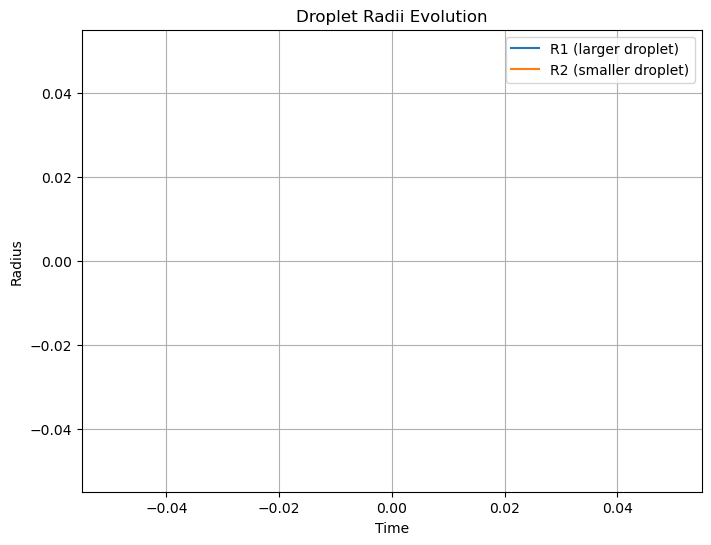

Could not track two droplets consistently.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import glob

# ---- Domain info ----
N = 128
s_start, s_end = -64, 64
x = np.linspace(s_start, s_end, N, endpoint=False)
y = np.linspace(s_start, s_end, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")
dx = abs(X[1,0] - X[0,0])

# ---- Load snapshot files ----
files = sorted(glob.glob("bubbly_phi_*.npy"), key=lambda f: int(f.split("_")[-1].split(".")[0]))
print(f"Found {len(files)} snapshots.")

# ---- Extract droplet radii over time ----
radii1, radii2, times = [], [], []

for f in files:
    phi = np.load(f)
    time = int(f.split("_")[-1].split(".")[0]) * 0.02   # timestep size = 0.02
    # Identify droplets
    mask = phi > 0
    labeled, num_features = label(mask)
    areas = [np.sum(labeled==i) for i in range(1, num_features+1)]
    if len(areas) >= 2:
        areas.sort(reverse=True)
        R1 = np.sqrt(areas[0] * dx**2 / np.pi)
        R2 = np.sqrt(areas[1] * dx**2 / np.pi)
        radii1.append(R1)
        radii2.append(R2)
        times.append(time)


radii1 = np.array(radii1)
radii2 = np.array(radii2)
times = np.array(times)

# ---- Plot radii evolution ----
plt.figure(figsize=(8,6))
plt.plot(times, radii1, label="R1 (larger droplet)")
plt.plot(times, radii2, label="R2 (smaller droplet)")
plt.xlabel("Time")
plt.ylabel("Radius")
plt.legend()
plt.title("Droplet Radii Evolution")
plt.grid(True)
plt.show()

# ---- Determine regime ----
if len(radii2) > 0:
    if radii2[-1] > radii2[0]:
        print("\nResult: Small droplet grows over time => Reverse Ostwald ripening (Region B/C).")
    else:
        print("\nResult: Small droplet shrinks over time => Forward Ostwald ripening (Region A).")
else:
    print("Could not track two droplets consistently.")


Found 96 snapshot files.


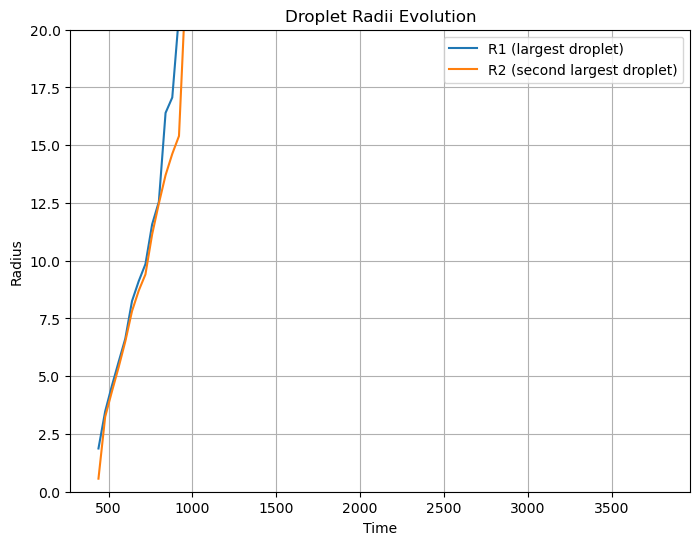


Result: Small droplet grows => Reverse Ostwald (Region B/C).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import glob
import os

# ---- Path to the .npy files ----
parent_dir = ".."  # adjust as needed
file_pattern = "bubbly_phi_*.npy"

# ---- Build the search path ----
search_path = os.path.join(parent_dir, file_pattern)

# ---- Find and sort files ----
files = sorted(glob.glob(search_path), key=lambda f: int(f.split("_")[-1].split(".")[0]))
print(f"Found {len(files)} snapshot files.")

# ---- Domain info ----
N = 128
s_start, s_end = -64, 64
x = np.linspace(s_start, s_end, N, endpoint=False)
y = np.linspace(s_start, s_end, N, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")
dx = abs(X[1,0] - X[0,0])

# ---- Extract droplet radii over time ----
radii1, radii2, times = [], [], []

for f in files:
    phi = np.load(f)
    time = int(f.split("_")[-1].split(".")[0]) * 0.02

    mask = phi > 0
    labeled, num_features = label(mask)

    areas = [np.sum(labeled==i) for i in range(1, num_features+1)]
    if len(areas) >= 2:
        areas.sort(reverse=True)
        R1 = np.sqrt(areas[0] * dx**2 / np.pi)
        R2 = np.sqrt(areas[1] * dx**2 / np.pi)
        radii1.append(R1)
        radii2.append(R2)
        times.append(time)

# ---- Plot radii evolution ----
if len(times) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(times, radii1, label="R1 (largest droplet)")
    plt.plot(times, radii2, label="R2 (second largest droplet)")
    plt.xlabel("Time")
    plt.ylabel("Radius")
    plt.legend()
    plt.grid(True)
    plt.title("Droplet Radii Evolution")
    plt.ylim(0, 20)  # adjust as needed
    plt.show()

    if radii2[-1] > radii2[0]:
        print("\nResult: Small droplet grows => Reverse Ostwald (Region B/C).")
    else:
        print("\nResult: Small droplet shrinks => Forward Ostwald (Region A).")
else:
    print("No droplets tracked! Check threshold or file content.")


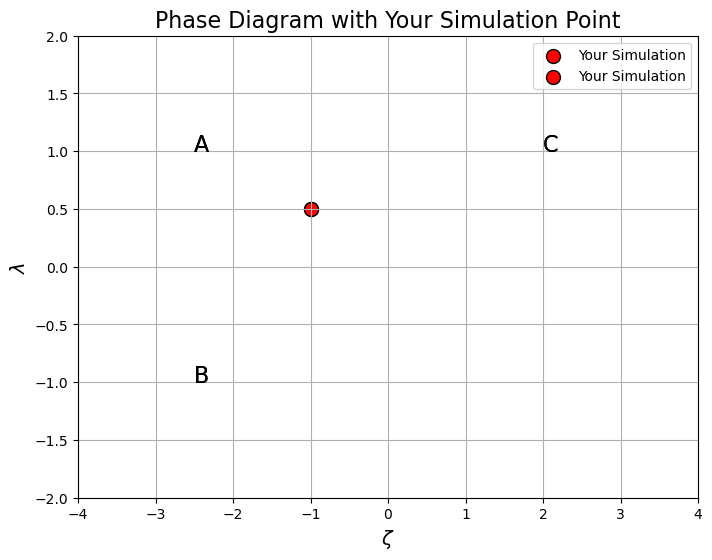

In [6]:
import matplotlib.pyplot as plt

# ---- Setup figure ----
fig, ax = plt.subplots(figsize=(8,6))

# ---- Plot background: manually sketch region boundaries (approximation) ----
# For illustration, we’ll add hand-drawn boundaries similar to Fig. 4a

# Dummy region boundaries (replace with accurate region boundaries if known!)
zeta_boundary = [-3, -2, 0, 2, 3]
lambda_boundary_A = [1.5, 1, 0, -1, -1.5]
lambda_boundary_B = [-1.5, -1, 0, 1, 1.5]
# Keep region labels and your simulation point:
ax.text(-2.5, 1.0, "A", fontsize=16, color="black")
ax.text(-2.5, -1.0, "B", fontsize=16, color="black")
ax.text(2.0, 1.0, "C", fontsize=16, color="black")
ax.scatter(zeta_sim, lambda_sim, color=color, s=100, label="Your Simulation", edgecolors='black')

# ---- Region labels ----
ax.text(-2.5, 1.0, "A", fontsize=16, color="black")
ax.text(-2.5, -1.0, "B", fontsize=16, color="black")
ax.text(2.0, 1.0, "C", fontsize=16, color="black")

# ---- Plot your simulation point ----
# Replace with your simulation’s parameters
zeta_sim = -1  # for example
lambda_sim = 0.5  # for example
regime = "Reverse Ostwald"  # result from radii tracking

# Color red for reverse (region B/C), blue for forward (region A)
color = 'red' if regime.startswith("Reverse") else 'blue'
ax.scatter(zeta_sim, lambda_sim, color=color, s=100, label="Your Simulation", edgecolors='black')

# ---- Customize plot ----
ax.set_xlabel(r'$\zeta$', fontsize=14)
ax.set_ylabel(r'$\lambda$', fontsize=14)
ax.set_title("Phase Diagram with Your Simulation Point", fontsize=16)
ax.legend()
ax.grid(True)
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)

plt.show()
